<a href="https://colab.research.google.com/github/TaraRasti/Deep_Learning_F20_Assignments/blob/master/Assignment_6/L2_Regularization/mnist_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mxnet

     |████████████████████████████████| 55.0MB 75kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np
ctx = mx.cpu()
mx.random.seed(1)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [5]:
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

for param in params:
    param.attach_grad()

def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = nd.softmax(y_linear, axis=1)
    return yhat

In [6]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [7]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [8]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 100. Train Loss: 0.5489038638770579, Test Loss 1.3389538563787937, Train_acc 0.874, Test_acc 0.713
Completed epoch 200. Train Loss: 0.2556498213671148, Test Loss 1.1792499795556066, Train_acc 0.938, Test_acc 0.744
Completed epoch 300. Train Loss: 0.1537529150955379, Test Loss 1.1424015387892723, Train_acc 0.97, Test_acc 0.757
Completed epoch 400. Train Loss: 0.09563161863479763, Test Loss 1.1284628584980965, Train_acc 0.984, Test_acc 0.763
Completed epoch 500. Train Loss: 0.06454555282834915, Test Loss 1.1195273250341415, Train_acc 0.991, Test_acc 0.768
Completed epoch 600. Train Loss: 0.046696525299921625, Test Loss 1.1108866557478903, Train_acc 0.996, Test_acc 0.772
Completed epoch 700. Train Loss: 0.03621075523551555, Test Loss 1.1026040017604826, Train_acc 1.0, Test_acc 0.776
Completed epoch 800. Train Loss: 0.029358359053730965, Test Loss 1.0955827608704567, Train_acc 1.0, Test_acc 0.781
Completed epoch 900. Train Loss: 0.024986527510918677, Test Loss 1.09044565632

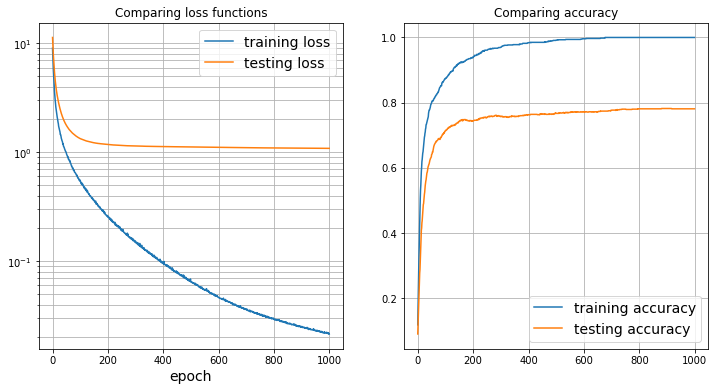

In [9]:
epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)


    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

##L2 Regularization



In [10]:
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
    return penalty

In [11]:
for param in params:
    param[:] = nd.random_normal(shape=param.shape)

Completed epoch 100. Train Loss: 0.4430665588006377, Test Loss 1.0297712981700897, Train_acc 0.891, Test_acc 0.726
Completed epoch 200. Train Loss: 0.21259281411767006, Test Loss 0.7258370947092772, Train_acc 0.957, Test_acc 0.781
Completed epoch 300. Train Loss: 0.15204936685040593, Test Loss 0.6082332152873278, Train_acc 0.977, Test_acc 0.816
Completed epoch 400. Train Loss: 0.13417055830359456, Test Loss 0.5528118032962085, Train_acc 0.984, Test_acc 0.826
Completed epoch 500. Train Loss: 0.1296755038201809, Test Loss 0.5257471241056919, Train_acc 0.99, Test_acc 0.838
Completed epoch 600. Train Loss: 0.12990672281011936, Test Loss 0.5122652966529131, Train_acc 0.991, Test_acc 0.839
Completed epoch 700. Train Loss: 0.1303533706814051, Test Loss 0.5048713143914938, Train_acc 0.992, Test_acc 0.842
Completed epoch 800. Train Loss: 0.13044994557276368, Test Loss 0.5026704557240007, Train_acc 0.992, Test_acc 0.841
Completed epoch 900. Train Loss: 0.1290220278315246, Test Loss 0.50046247430

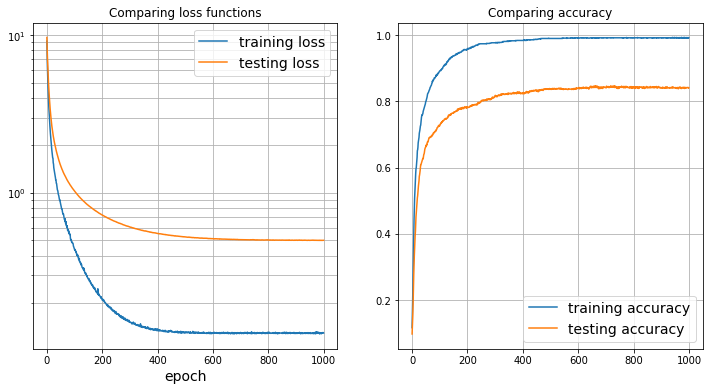

In [12]:
epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)


    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)


    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

By adding 𝐿2
L
2
 regularization we were able to increase the performance on test data from 75% accuracy to 83% accuracy. That’s a 32% reduction in error.